### 线性回归

给定一个数据点集合X和对应的目标值Y，线性模型的目标就是找到一条使用向量$w$和位移$b$描述的线，来尽可能的近似每个样本$X[i]$和$Y[i]$。
用数学符号来表示就是：

$$\hat{y} = Xw + b$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
xx = np.linspace(-0.75, 1.,100)

fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(xx, xx + 0.25 * np.random.randn(len(xx)))
ax.plot(xx, xx, lw=3)
ax.set_title('line')
ax.grid(True)

并最小化所有数据点上的平方误差(平方损失函数来度量模型好坏)

$$\sum_{i=1}^n (\hat{y}_i - y_i)^2.$$

线性回归是一个两层的神经网络，一个输入层，一个输出层。以($f(x) = x$)来作为激活函数.

![](http://zh.gluon.ai/_images/onelayer.png)

### 创建数据集

数据集对应关系：

$$y = X \cdot w + b + \eta, \quad \text{for } \eta \sim \mathcal{N}(0,\sigma^2)$$

In [2]:
from mxnet import ndarray as nd
from mxnet import autograd

num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

X = nd.random_normal(shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(shape=y.shape)

In [3]:
X.shape

(1000, 2)

In [4]:
y.shape

(1000,)

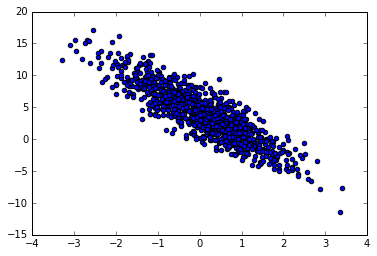

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(), y.asnumpy())
plt.show()

数据读取

In [6]:
import random
batch_size = 10 #步长，每次取10个数
def data_iter():
    # 产生一个随机索引
    idx = list(range(num_examples)) # idx 的 结果为：[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    random.shuffle(idx) # 将idx打乱
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size,num_examples)]) # idx[i:min] 结果为：[1, 3, 5, 0, 2]
        yield nd.take(X, j), nd.take(y, j)

In [7]:
for data, label in data_iter():
    print(data, label)
    break


[[ 0.80084276  1.64351559]
 [ 0.2963081   0.87118691]
 [-0.60309178  0.18327411]
 [ 1.44050789 -0.74336916]
 [ 0.37795901 -0.34565544]
 [-2.06444263  0.50765425]
 [ 0.59524769 -2.19519234]
 [-0.7974264  -0.5284977 ]
 [ 0.92134416 -0.31523219]
 [-0.30573937 -0.95906508]]
<NDArray 10x2 @cpu(0)> 
[  0.18612839   1.83015716   2.36237001   9.60223007   6.12610054
  -1.65116966  12.8497858    4.42113304   7.12984419   6.85699129]
<NDArray 10 @cpu(0)>


### 初始化模型参数

In [8]:
w = nd.random_normal(shape=(num_inputs, 1))
b = nd.zeros((1,))
params = [w, b]

In [17]:
print(w)
print(b)


[[ 2.00065613]
 [-3.40085959]]
<NDArray 2x1 @cpu(0)>

[ 4.20083332]
<NDArray 1 @cpu(0)>


获取参数的梯度（导数）

In [9]:
for param in params:
    param.attach_grad()

### 定义模型

In [19]:
def net(X):
    return nd.dot(X, w) + b # X * w + b

In [20]:
net(data)


[[  6.63113403]
 [ 12.89867401]
 [  2.26303554]
 [ -0.6449585 ]
 [  0.0784359 ]
 [  0.10403013]
 [  8.81071663]
 [ -2.80406713]
 [ 11.78443146]
 [  9.61425209]]
<NDArray 10x1 @cpu(0)>

### 损失函数

使用平方误差来衡量预测目标和真实目标之间的差距

In [11]:
def square_loss(yhat, y):
    # 注意这里我们把y变形成yhat的形状来避免矩阵形状的自动转换
    return (yhat - y.reshape(yhat.shape)) ** 2

### 优化

使用随机梯度下降，下降的距离称之为学习率

In [12]:
def SGD(params, lr): # lr -> learningRate...
    for param in params:
        param[:] = param - lr * param.grad

## 训练

In [13]:
# 模型函数
def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2
# 绘制损失随训练次数降低的折线图，以及预测值和真实值的散点图
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '*g', label='Real')
    fg2.legend()
    plt.show()

Epoch 0, batch 99. Moving avg of loss: 1.52529489039. Average loss: 2.398108


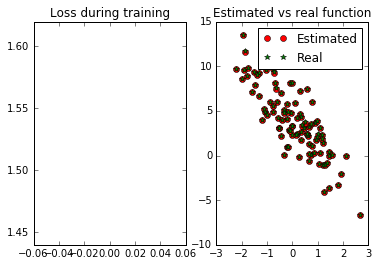

Epoch 1, batch 199. Moving avg of loss: 0.407040470324. Average loss: 0.000112


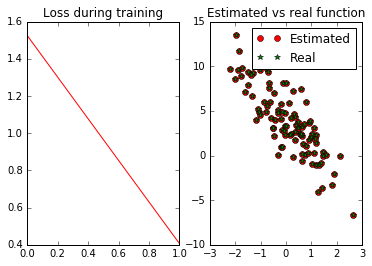

Epoch 2, batch 299. Moving avg of loss: 0.135608037392. Average loss: 0.000101


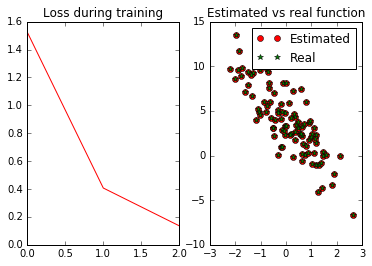

Epoch 3, batch 399. Moving avg of loss: 0.0481133483252. Average loss: 0.000100


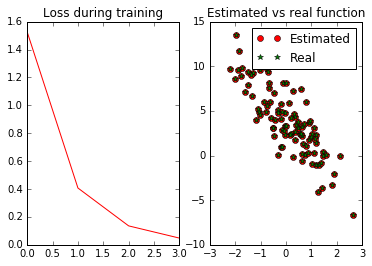

Epoch 4, batch 499. Moving avg of loss: 0.0174736454433. Average loss: 0.000100


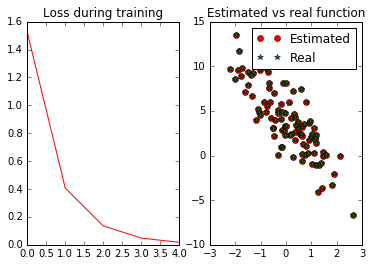

In [14]:
epochs = 5
learning_rate = .003
niter = 0
losses = []
moving_loss = 0
smoothing_constant = .01

# 训练
for e in range(epochs):    
    total_loss = 0

    for data, label in data_iter():
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        total_loss += nd.sum(loss).asscalar()

        # 记录每读取一个数据点后，损失的移动平均值的变化；
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)

        if (niter + 1) % 100 == 0:
            losses.append(est_loss)
            print("Epoch %s, batch %s. Moving avg of loss: %s. Average loss: %f" % (e, niter, est_loss, total_loss/num_examples))
            plot(losses, X)

In [15]:
true_w, w

([2, -3.4], 
 [[ 2.00065613]
  [-3.40085959]]
 <NDArray 2x1 @cpu(0)>)

In [16]:
true_b, b

(4.2, 
 [ 4.20083332]
 <NDArray 1 @cpu(0)>)